In [1]:
from qiskit_machine_learning.datasets.dataset_helper import (
    features_and_labels_transform
)

from sklearn.datasets import make_blobs
from sklearn.datasets import load_breast_cancer

from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC

In [2]:
"""
breast cancer dataset
"""

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from qiskit.utils import optionals
from qiskit_machine_learning.datasets.dataset_helper import (features_and_labels_transform)



# train_size=20
# test_size=30
# n=2
# plot_data=True
# one_hot=True


def reduce_data(train_size=0.7,dataset=None,test_size=0.3,dimension=2,plot_data=True,one_hot=False,
                sample_train=None, sample_test=None, label_train=[], label_test=None,title="Sample Diagram"):
    
    if len(dataset)>0:
        data =dataset["data"]
        target = dataset["target"]
        class_labels = np.unique(target).tolist()
        sample_train, sample_test, label_train, label_test = train_test_split(
            data, target, train_size=train_size,test_size=test_size, random_state=12)
    else:
        class_labels = np.unique(label_train).tolist()
        
    if type(test_size)==float or type(train_size)==float :
        test_size=len(label_test)
        train_size=len(label_train)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=dimension).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {
        key: (sample_train[label_train == k, :])[:train_size]
        for k, key in enumerate(class_labels)
    }
    test_input = {
        key: (sample_test[label_test == k, :])[:test_size] for k, key in enumerate(class_labels)
    }
    training_feature_array, training_label_array = features_and_labels_transform(
        training_input, class_labels, one_hot
    )
    test_feature_array, test_label_array = features_and_labels_transform(
        test_input, class_labels, one_hot
    )

    if plot_data:
        # optionals.HAS_MATPLOTLIB.require_now("breast_cancer")
        # pylint: disable=import-error
        import matplotlib.pyplot as plt

        for k in range(0, 2):
            #gets the xy cordinateds for each classes
            plt.scatter(
                sample_train[label_train == k, 0][:train_size],
                sample_train[label_train == k, 1][:train_size],
            )
        plt.legend(class_labels)
        plt.title(f"PCA dim.{dimension} reduced {title} dataset")
        plt.show()

    return(
        training_feature_array,
        training_label_array,
        test_feature_array,
        test_label_array)

# QNN


In [3]:
dataset=load_breast_cancer()

In [28]:
from hyperopt.pyll.base import scope
from hyperopt import fmin, hp, tpe, Trials, space_eval
from sklearn.model_selection import cross_val_score
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

from hyperopt.pyll.base import scope
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll import scope

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [30]:
# space = {"c": hp.uniform("c", -10, 10)}
# scope.int(hp.quiniform('my_param', 1, 100, q=1))


space ={"q":hp.choice("q",list(range(2,5)))}

# define objective function
def model(params):
    
    q=params["q"]
    # construct QNN
    qc = QuantumCircuit(q)
    feature_map = ZZFeatureMap(q)
    ansatz = RealAmplitudes(q)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    train_features,train_labels,test_features,test_labels = reduce_data(dataset=dataset,
                                                                  train_size=0.7,
                                                                  test_size=0.3,
                                                                  dimension=q,
                                                                  plot_data=False,
                                                                  one_hot=False,
                                                                  title="Breast Cancer SK learn")
    
    estimator_qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters)
    
    estimator_classifier = NeuralNetworkClassifier(
        estimator_qnn, optimizer=COBYLA())
    
    return estimator_classifier,train_features,train_labels,test_features,test_labels

def hyperparameter_tuning(params):
    clf,train_features,train_labels,test_features,test_labels = model(params)
    clf.fit(train_features, train_labels)

    score = clf.score(test_features, test_labels)
 
    return {"loss": -1 * score, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials,
    early_stop_fn=no_progress_loss(iteration_stop_count=10,
                                   percent_increase=0.0),
)

100%|███████████████████████████████████████| 10/10 [6:09:49<00:00, 2218.96s/trial, best loss: -0.6081871345029239]


In [32]:
best

{'q': 0}

In [33]:
list(trials)

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.6081871345029239, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'q': [0]},
   'vals': {'q': [0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 12, 5, 2, 12, 39, 239000),
  'refresh_time': datetime.datetime(2022, 12, 5, 2, 21, 10, 41000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.6081871345029239, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'q': [1]},
   'vals': {'q': [0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 12, 5, 2, 21, 10, 43000),
  'refresh_time': datetime.datetime(2022, 12, 5, 2, 25, 31, 82000)},
 {'state': 2,
  'tid': 2,
  'spec': None,
  'result': {'loss': -0.5321637426900585, 'status': 'ok'},
  'misc': {'tid': 2,
   'cmd': ('domain_atta

In [34]:
space_final ={"q":list(range(2,5))}

In [36]:
print(f'q:{space_final["q"][best["q"]]}')

q:2


In [37]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [68]:
q=space_final["q"][best["q"]]
# construct QNN
qc = QuantumCircuit(q)
feature_map = ZZFeatureMap(q)
ansatz = RealAmplitudes(q)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")
train_features,train_labels,test_features,test_labels = reduce_data(dataset=dataset,
                                                              train_size=0.7,
                                                              test_size=0.3,
                                                              dimension=q,
                                                              plot_data=False,
                                                              one_hot=False,
                                                              title="Breast Cancer SK learn")

estimator_qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters)

# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(), callback=callback_graph
)

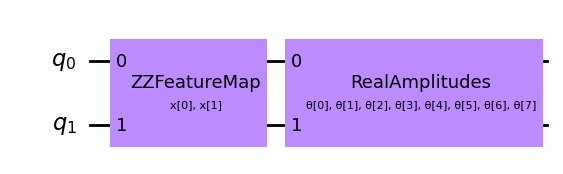

In [69]:
qc.draw(output="mpl")

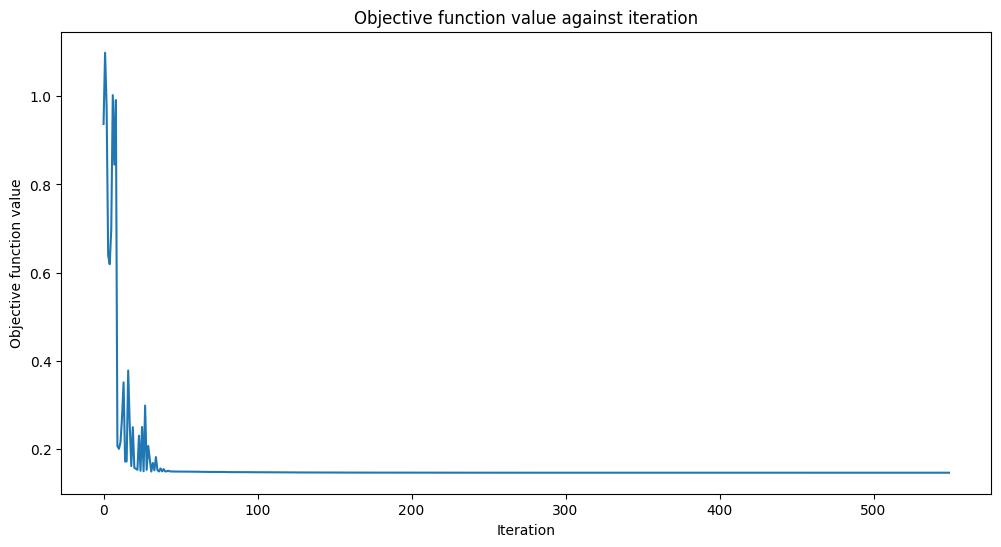

CPU times: user 18min 23s, sys: 50.9 s, total: 19min 14s
Wall time: 18min 5s


0.6081871345029239

In [40]:
%%time
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(train_features, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(test_features, test_labels)

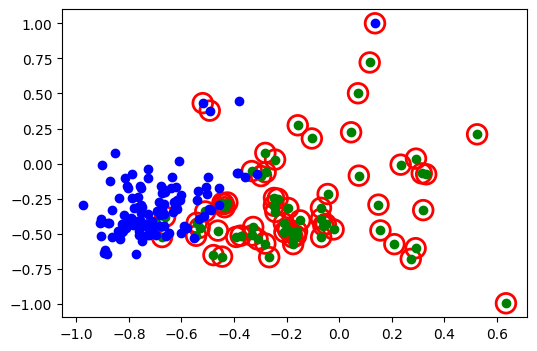

In [56]:
# evaluate data points
y_predict = estimator_classifier.predict(test_features)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(test_features, test_labels, y_predict):
    # plt.hold(True)
    if y_target == 1:
        plt.plot(x[0], x[1], "bo",label="Class1")
        # plt.legend(["Class 1"])
    else:
        plt.plot(x[0], x[1], "go",label="Class0")
        # plt.legend(["Class 0"])
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2,label="Wrongly Classified")
        # plt.legend(["Wrongly classified"])
# plt.legend(loc='upper left')
plt.show()

In [58]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [61]:
# y_predict

In [67]:
from sklearn.metrics import classification_report

target_names = ["Class 1","Class 0"]
report=classification_report(y_true=test_labels, y_pred=y_predict,output_dict=True)

/home/edwin/toc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edwin/toc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edwin/toc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edwin/toc/lib/python3.7/site-packages/sklearn/metrics/

In [59]:
print(classification_report(y_true=test_labels, y_pred=y_predict))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.00      0.00      0.00        64
         1.0       0.65      0.97      0.78       107

    accuracy                           0.61       171
   macro avg       0.22      0.32      0.26       171
weighted avg       0.40      0.61      0.49       171



/home/edwin/toc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edwin/toc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edwin/toc/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/edwin/toc/lib/python3.7/site-packages/sklearn/metrics/

In [62]:
# plot confusion matrix: reference: 
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
cm=confusion_matrix(y_true=test_labels, y_pred=y_predict)

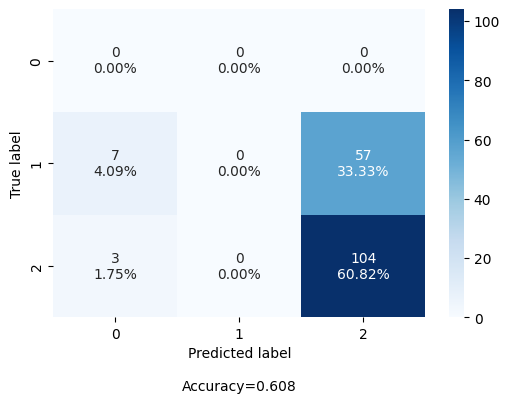

In [66]:
make_confusion_matrix(cm)